# Chapter 8 - Online Learning for Time Series

In [33]:
import numpy as np

from river import drift

%matplotlib inline
%load_ext autoreload
%autoreload 2
%load_ext lab_black

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [34]:
drift_detector = drift.ADWIN()

np.random.seed(12345)
data_stream = np.concatenate(
    (np.random.randint(2, size=1000), np.random.randint(8, size=1000))
)

In [36]:
def perform_test(drift_detector, data_stream):
    detected_indices = []
    for i, val in enumerate(data_stream):
        in_drift, in_warning = drift_detector.update(val)
        if in_drift:
            detected_indices.append(i)
    return detected_indices

In [37]:
perform_test(drift_detector, data_stream)

[1055, 1087, 1215]

/var/folders/63/m20qx7592pb4b2zvqmy711qc0000gn/T/ipykernel_7286/4222344745.py:7: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ro" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(


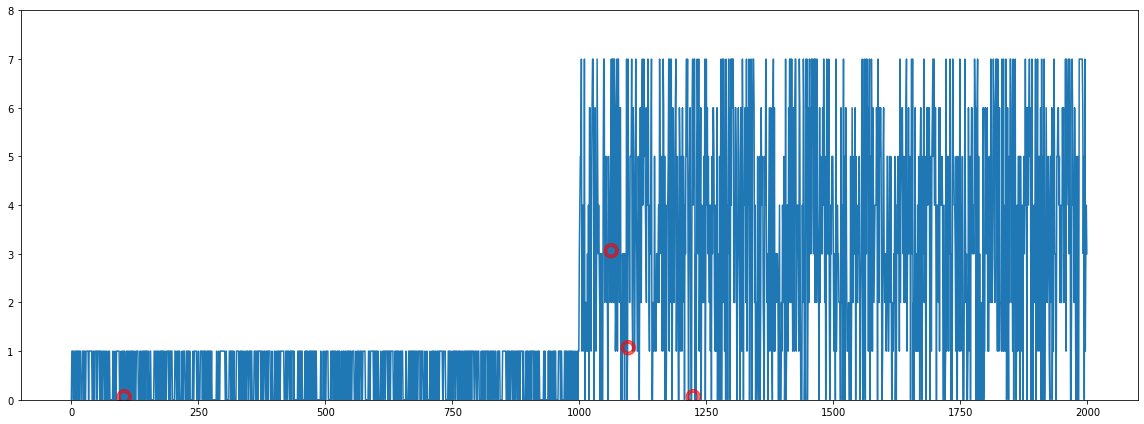

In [45]:
import matplotlib.pyplot as plt


def show_drift(data_stream, indices):
    fig, ax = plt.subplots(figsize=(16, 6))
    ax.plot(data_stream)
    ax.plot(
        indices,
        data_stream[indices],
        "ro",
        alpha=0.6,
        marker=r"$\circ$",
        markersize=22,
        linewidth=4,
    )
    # ax.set_xlim([1000, 1300])
    ax.set_ylim([0, 8])


show_drift(data_stream, perform_test(drift_detector, data_stream))
plt.tight_layout()
plt.show()

## Regression

We are going to estimate the occurrence of medium-class solar flares.  

For this, we'll use the solar flares dataset from the UCI machine learning repository.
The River library ships with a zipped column-separated dataset of the dataset, and
we'll load this, specify the column types, and choose the outputs we are interested in.  

Let's plot the ADWIN results now:

In [8]:
from river import stream
from river.datasets import base


class SolarFlare(base.FileDataset):
    def __init__(self):
        super().__init__(
            n_samples=1066,
            n_features=10,
            n_outputs=1,
            task=base.MO_REG,
            filename="solar-flare.csv.zip",
        )

    def __iter__(self):
        return stream.iter_csv(
            self.path,
            target="m-class-flares",
            converters={
                "zurich-class": str,
                "largest-spot-size": str,
                "spot-distribution": str,
                "activity": int,
                "evolution": int,
                "previous-24h-flare-activity": int,
                "hist-complex": int,
                "hist-complex-this-pass": int,
                "area": int,
                "largest-spot-area": int,
                "c-class-flares": int,
                "m-class-flares": int,
                "x-class-flares": int,
            },
        )

In [46]:
from pprint import pprint
from river import datasets

for x, y in SolarFlare():
    pprint(x)
    pprint(y)
    break

{'activity': 1,
 'area': 1,
 'c-class-flares': 0,
 'evolution': 3,
 'hist-complex': 1,
 'hist-complex-this-pass': 1,
 'largest-spot-area': 1,
 'largest-spot-size': 'A',
 'previous-24h-flare-activity': 1,
 'spot-distribution': 'X',
 'x-class-flares': 0,
 'zurich-class': 'H'}
0


We see the ten feature columns as a dictionary and the output as a float.

In [47]:
import numbers
from river import compose
from river import preprocessing
from river import tree

num = compose.SelectType(numbers.Number) | preprocessing.MinMaxScaler()
cat = compose.SelectType(str) | preprocessing.OneHotEncoder(sparse=False)
model = tree.HoeffdingTreeRegressor()
pipeline = (num + cat) | model

A pipeline like this is very pleasant to read: numeric features get min-max scaled,
while string features get one-hot encoded. The preprocessed features get fed into a
Hoeffding Tree model for regression.  

We can now learn our model prequentially, by predicting values and then training
them as discussed before:

In [48]:
from river import evaluate
from river import metrics

metric = metrics.MAE()
evaluate.progressive_val_score(SolarFlare(), pipeline, metric)

MAE: 0.096979

This prequential evaluation evaluate.progressive_val_score() is equivalent to the
following:

In [49]:
errors = []
for x, y in SolarFlare():
    y_pred = pipeline.predict_one(x)
    metric = metric.update(y, y_pred)
    errors.append(metric.get())
    pipeline = pipeline.learn_one(x, y)

I've added two extra lines to collect the error over time as the algorithm learns.  

Let's plot this:

Text(0, 0.5, 'MAE')

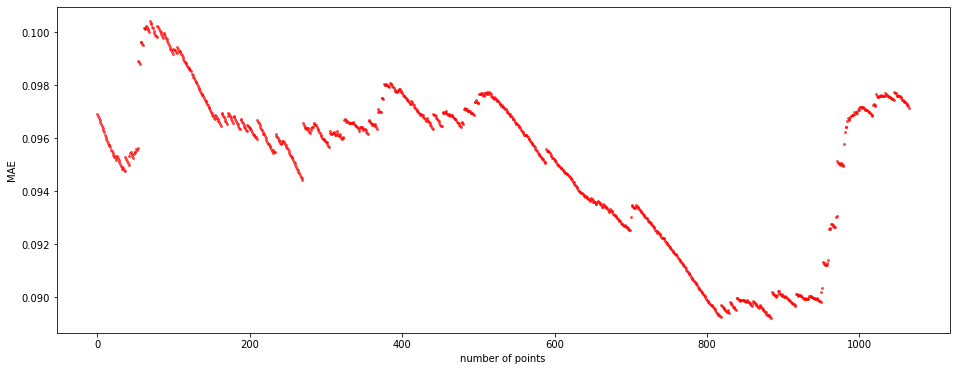

In [50]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(errors, "ro", alpha=0.6, markersize=2, linewidth=4)
ax.set_xlabel("number of points")
ax.set_ylabel("MAE")

This plot shows how this error evolves as a function of the number of points the
algorithm encounters:

We can see that, after 20-30 points, after the metric stabilizes, the Hoeffding Tree starts learning and the error keeps decreasing until about 800 points, at which point the error increases again. This could be a row ordering effect.  

A dataset that has concept drift is the use case for an adaptive model. Let's compare adaptive and non-adaptive models on a dataset with concept drift:

In [51]:
from river import synth, ensemble, tree, evaluate, metrics

models = [
    tree.HoeffdingTreeRegressor(),
    tree.HoeffdingAdaptiveTreeRegressor(),
    ensemble.AdaptiveRandomForestRegressor(seed=42),
]

We will compare the Hoeffding Tree Regressor, the Adaptive Hoeffding Tree
Regressor, and the Adaptive Random Forest Regressor. We take the default settings
for each model.  

We can use a synthetic dataset for this test. We can train each of the aforementioned models on the data stream and look at the Mean Squared Error (MSE) metric:  

The evaluate.progressive_val_score method iterates over each point of the dataset
and updates the metric. We get the following result:

In [52]:
for model in models:
    metric = metrics.MSE()
    dataset = synth.ConceptDriftStream(seed=42, position=500, width=40).take(1000)
    evaluate.progressive_val_score(dataset, model, metric)
    print(f"{str(model.__class__).split('.')[-1][:-2]}: {metric.get():e}")

HoeffdingTreeRegressor: 8.427388e+42
HoeffdingAdaptiveTreeRegressor: 8.812791e+42
AdaptiveRandomForestRegressor: 1.657685e+42


# Model selection

We've mentioned model selection with multi-armed bandits earlier in this chapter,
and here we'll go through a practical example. This is based on documentation in
River.  

Let's use UCBRegressor to select the best learning rate for a linear regression model.
The same pattern can be used more generally to select between any set of (online)
regression models.  

First, we define the models:

In [53]:
from river import compose
from river import linear_model
from river import preprocessing
from river import optim

In [54]:
models = [
    compose.Pipeline(
        preprocessing.StandardScaler(),
        linear_model.LinearRegression(optimizer=optim.SGD(lr=lr)),
    )
    for lr in [1e-4, 1e-3, 1e-2, 1e-1]
]

We build and evaluate our models on the TrumpApproval dataset:

In [55]:
from river import datasets

dataset = datasets.TrumpApproval()

We'll apply the UCB bandit, which calculates reward for regression models:

In [56]:
from river.model_selection import UCBRegressor

bandit = UCBRegressor(models=models, seed=1)

The bandit provides methods to train its models in an online fashion:

In [57]:
for x, y in dataset:
    bandit = bandit.learn_one(x=x, y=y)

We can inspect the number of times (as a percentage) each arm has been pulled.  
The percentages for the four models are as follows:

In [58]:
for model, pct in zip(bandit.models, bandit.percentage_pulled):
    lr = model["LinearRegression"].optimizer.learning_rate
    print(f"{lr:.1e} — {pct:.2%}")

AttributeError: 'UCBRegressor' object has no attribute 'percentage_pulled'

We can also look at the average reward of each model:

In [30]:
for model, avg in zip(bandit.models, bandit.average_reward):
    lr = model["LinearRegression"].optimizer.learning_rate
    print(f"{lr:.1e} — {avg:.2f}")

AttributeError: 'UCBRegressor' object has no attribute 'average_reward'

We can also select the best model (the one with the highest average reward).

In [59]:
best_model = bandit.best_model

In [60]:
best_model["LinearRegression"].intercept_lr.learning_rate

0.01